In [25]:
import matplotlib.pyplot as plt
import os
import requests
import numpy as np  
import urllib.request
from joblib import Parallel, delayed
import time
import pandas as pd

In [26]:
#1: cargando las imagenes en un array
im_ar=np.loadtxt('20_images.txt', dtype='str')
im_ar

array(['https://i.ytimg.com/vi/bDPkImgNs8Y/maxresdefault.jpg',
       'https://e00-marca.uecdn.es/albumes/2014/11/18/comics_nba/1416295630_extras_albumes_0_980.jpg',
       'https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/fairy-tail-natsu-padres-1559572361.png',
       'https://static.wikia.nocookie.net/fairytail/images/b/bf/830px-You_like_him.jpg/revision/latest?cb=20120127154134&path-prefix=es',
       'https://static.wikia.nocookie.net/doblaje/images/7/7c/Dragon-Ball-Z.png/revision/latest?cb=20200911193425&path-prefix=es',
       'https://depor.com/resizer/EkdERO36Wj8BqMsc67Kd20z2f0U=/1200x1200/smart/filters:format(jpeg):quality(75)/cloudfront-us-east-1.images.arcpublishing.com/elcomercio/NRFDECK2RBDCTKHGOOT5XJQEDI.jpg',
       'https://www.rd.com/wp-content/uploads/2019/01/shutterstock_673465372.jpg?fit=700,467',
       'https://images.unsplash.com/photo-1611267254323-4db7b39c732c?ixlib=rb-4.0.3&ixid=MnwxMjA3fDB8MHxzZWFyY2h8M3x8Y3V0ZSUyMGNhdHxlbnwwfHwwfHw%3D&w=1000&q=8

In [27]:
#Descargo las imagenes en el docker
folder='/media'
images_array=[]

for url in im_ar:
    response=requests.get(url)
    im=url.split('/')[-1]
    with open(os.path.join(folder, im), 'wb') as f:
        f.write(response.content)
    images_array.append(im)

images_array

['maxresdefault.jpg',
 '1416295630_extras_albumes_0_980.jpg',
 'fairy-tail-natsu-padres-1559572361.png',
 'latest?cb=20120127154134&path-prefix=es',
 'latest?cb=20200911193425&path-prefix=es',
 'NRFDECK2RBDCTKHGOOT5XJQEDI.jpg',
 'shutterstock_673465372.jpg?fit=700,467',
 'photo-1611267254323-4db7b39c732c?ixlib=rb-4.0.3&ixid=MnwxMjA3fDB8MHxzZWFyY2h8M3x8Y3V0ZSUyMGNhdHxlbnwwfHwwfHw%3D&w=1000&q=80',
 '20523050.png',
 '41b9u-1yUVS._AC_.jpg',
 'cthulhu-2.jpg?w=640',
 'il_1080xN.3926159075_hj39.jpg',
 'fan-art-chihiro-7.jpg',
 '557b36ec0911375e91f88c45b9e30a92--batman-animado-chibi.jpg',
 'il_fullxfull.4384629284_5nk6.jpg',
 'CEIJaGZP_400x400.jpg',
 'latest?cb=20160511154723&path-prefix=es',
 'tvkk3sxgp8181.png',
 'Ew7fd58XIAIvPRs.png',
 'eed60545d30bafa2dd7ce23e9c076801--los-simpsons-cartoon-characters.jpg',
 'elephant-297205_960_720-768x558.png',
 'D_NQ_NP_2X_947005-MLM49480089581_032022-F.jpg',
 '787.jpg?w=1000&ssl=1',
 'road-1072823_1280.jpg',
 '0144502500_gtr_cntbdyright_001_nr_1024x1024

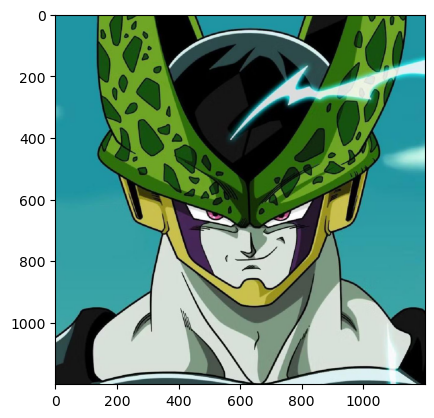

In [28]:
prueba=plt.imread(folder+'/'+images_array[5])
plt.imshow(prueba)

In [29]:
#2: Transformar las images a vectores
#Creo la funcion que va a vectorizar
def vect(x):
    try:
        return plt.imread(x)
    except:
        pass


In [30]:
ims_vectors=Parallel(n_jobs=5)(delayed(vect)(folder+'/'+im) for im in images_array)

In [34]:
#Existen links rotos
remove=[6, 18, 33]
imgs_vectors=np.delete(ims_vectors, remove)

In [35]:
def change_colors(im):
    copy=im.copy()
    rand=np.random.randint(0,2)
    old_color=copy[0,0,rand]
    new_color=np.random.uniform(0, 255)
    copy[:,:,rand]=new_color
    return copy, old_color, new_color
    

In [36]:
altered_images, old_colors, new_colors=zip(*Parallel(n_jobs=5)(delayed(change_colors)(i) for i in imgs_vectors))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


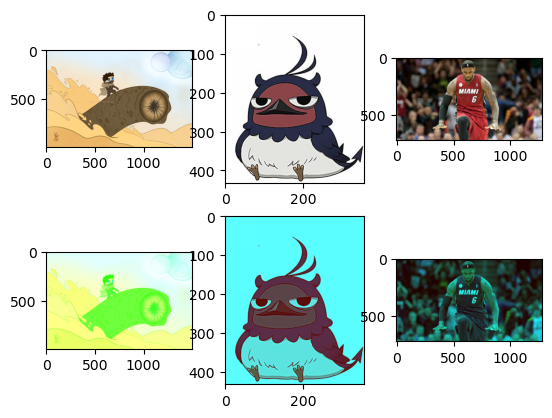

In [38]:
fig, axes= plt.subplots(nrows=2, ncols=3)

axes[0,0].imshow(imgs_vectors[16])
axes[1,0].imshow(altered_images[16])
axes[0,1].imshow(imgs_vectors[8])
axes[1,1].imshow(altered_images[8])
axes[0,2].imshow(imgs_vectors[0])
axes[1,2].imshow(altered_images[0])

plt.show()

In [39]:
#quitamos de nuestro array de urls los defectuosos
urls=np.delete(images_array, remove)

In [40]:
#Generamos el dataframe a partir de un diccionario
dict_resp={'urls':urls, 'old color':old_colors, 'new color':new_colors}

df=pd.DataFrame(dict_resp)
df.head()

,urls,old color,new color
0,maxresdefault.jpg,60.000000,31.974361
1,1416295630_extras_albumes_0_980.jpg,255.000000,174.451450
2,fairy-tail-natsu-padres-1559572361.png,0.992157,232.485264
3,latest?cb=20120127154134&path-prefix=es,190.000000,221.960459
4,latest?cb=20200911193425&path-prefix=es,0.627451,162.921152


In [41]:
#Generamos la nueva columna que es la diferencia entre colores paralelizadamente
def resta(a, b):
    return a-b

In [42]:
dif=Parallel(n_jobs=5)(delayed(resta)(old_colors[i], new_colors[i]) for i in range(len(old_colors)))
dif=np.array(dif)

In [43]:
df['diferencia']=dif
df

,urls,old color,new color,diferencia
0,maxresdefault.jpg,60.000000,31.974361,28.025639
1,1416295630_extras_albumes_0_980.jpg,255.000000,174.451450,80.548550
2,fairy-tail-natsu-padres-1559572361.png,0.992157,232.485264,-231.493107
3,latest?cb=20120127154134&path-prefix=es,190.000000,221.960459,-31.960459
4,latest?cb=20200911193425&path-prefix=es,0.627451,162.921152,-162.293701
5,NRFDECK2RBDCTKHGOOT5XJQEDI.jpg,31.000000,112.338457,-81.338457
6,photo-1611267254323-4db7b39c732c?ixlib=rb-4.0....,81.000000,59.915506,21.084494
7,20523050.png,0.337255,220.669692,-220.332437
8,41b9u-1yUVS._AC_.jpg,255.000000,91.721000,163.279000
9,cthulhu-2.jpg?w=640,88.000000,204.988612,-116.988612
